In [1]:
from numpy.random import seed
seed(8)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, model_selection
%matplotlib inline

In [2]:
#load and preprocess data
def read_in_and_split_data(iris_data):
    """
    Takes the Iris dataset as loaded by sklearn.datasets.load_iris(), and then splits so that the training set includes 
    90% of the full dataset, with the test set making up the remaining 10%.
    Returns a tuple (train_data, test_data, train_targets, test_targets) of appropriately split training and test data and 
    targets.
    """
    data = iris_data['data']
    targets = iris_data['target']
    
    train_data, test_data, train_targets, test_targets = model_selection.train_test_split(data, targets, test_size = 0.1)
    
    return train_data, test_data, train_targets, test_targets

iris_data = datasets.load_iris()
train_data, test_data, train_targets, test_targets = read_in_and_split_data(iris_data)

In [3]:
#covert targets to a one-hot encoding
train_targets = tf.keras.utils.to_categorical(np.array(train_targets))
test_targets = tf.keras.utils.to_categorical(np.array(test_targets))

In [4]:
#build the model
def get_model(input_shape):
    """
    Builds and returns a Sequential model.
    """
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, input_shape = (train_data.shape[1],), 
                              kernel_initializer = tf.keras.initializers.HeUniform(),
                             bias_initializer = tf.keras.initializers.Constant(value=0)),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(3, activation = 'softmax'),
        
    ])
    return model

model = get_model(train_data[0].shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4

In [5]:
#compile the model
def compile_model(model):
    """
    Takes in the model returned from your get_model function, and compiles it with an optimiser, loss function and metric.
    Compile the model using the Adam optimiser (with learning rate set to 0.0001), the categorical crossentropy loss function 
    and accuracy as the only metric. 
    """
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss = tf.keras.losses.CategoricalCrossentropy(),
        metrics = ['accuracy']
    )
compile_model(model)

In [6]:
#model training
def train_model(model, train_data, train_targets, epochs):
    """
    Train the model for the given number of epochs on the train_data and train_targets. 
    Return the training history, as returned by model.fit.
    """
    history = model.fit(train_data, train_targets, epochs = epochs, batch_size = 40, validation_split = 0.15, verbose = 0)
    return history

history = train_model(model, train_data, train_targets, epochs = 800)

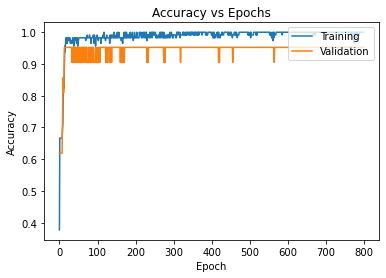

In [7]:
#plot learning curves
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except Keyerror:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend(["Training", "Validation"], loc = 'upper right')
plt.show()

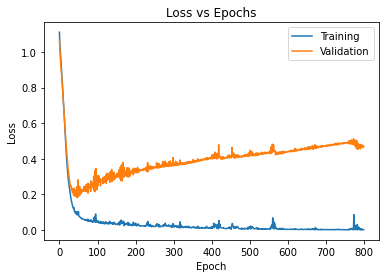

In [8]:
#epoch vs loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc = 'upper right')
plt.show()

In [9]:
#regularized model
def get_regularized_model(input_shape, dropout_rate, weight_decay):
    """
    Build a regularised Sequential model according to the above specification. 
    The dropout_rate argument in the function is used to set the Dropout rate for all Dropout layers.
    L2 kernel regularisation (weight decay) is added using the weight_decay argument to set the weight decay coefficient in all 
    Dense layers that use L2 regularisation.
    Your function should return the model.
    """
    l2_reg = tf.keras.regularizers.L2(l2 = weight_decay )
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, input_shape = (train_data.shape[1],), 
                              kernel_initializer = tf.keras.initializers.HeUniform(),
                              bias_initializer = tf.keras.initializers.Constant(value=0),
                              kernel_regularizer = l2_reg),
        tf.keras.layers.Dense(128, activation = 'relu', kernel_regularizer = l2_reg),
        tf.keras.layers.Dense(128, activation = 'relu', kernel_regularizer = l2_reg),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(128, activation = 'relu', kernel_regularizer = l2_reg),
        tf.keras.layers.Dense(128, activation = 'relu', kernel_regularizer = l2_reg),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation = 'relu', kernel_regularizer = l2_reg),
        tf.keras.layers.Dense(64, activation = 'relu', kernel_regularizer = l2_reg),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(64, activation = 'relu', kernel_regularizer = l2_reg),
        tf.keras.layers.Dense(64, activation = 'relu', kernel_regularizer = l2_reg),
        tf.keras.layers.Dense(3, activation = 'softmax'),
        
    ])
    return model
#Instantiate the model, using a dropout rate of 0.3 and weight decay coefficient of 0.001
reg_model = get_regularized_model(train_data[0].shape, 0.3, 0.001)
compile_model(reg_model) # Compile the model
reg_history = train_model(reg_model, train_data, train_targets, epochs = 800) # Train the model

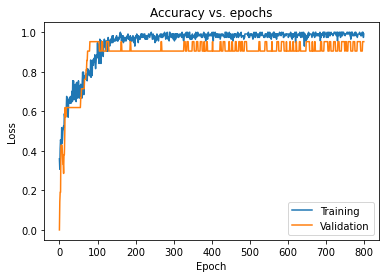

In [10]:
#accuracy vs epoch graph
try:
    plt.plot(reg_history.history['accuracy'])
    plt.plot(reg_history.history['val_accuracy'])
except KeyError:
    plt.plot(reg_history.history['acc'])
    plt.plot(reg_history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

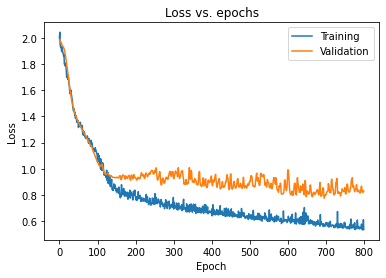

In [11]:
#new loss vs epoch graph
plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [12]:
#callbacks for earl stopping and learning rate reduction
def get_callbacks():
    """
    Create and return a tuple (early_stopping, learning_rate_reduction) callbacks.
    The callbacks are instantiated according to the above requirements.
    """
    earlystopping = tf.keras.callbacks.EarlyStopping(mode='min', patience = 30)
    learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=20)
    return earlystopping, learning_rate_reduction

In [13]:
call_model = get_regularized_model(train_data[0].shape, 0.3, 0.0001) #initialize the model
compile_model(call_model) #compile the model
early_stopping, learning_rate_reduction = get_callbacks() #initialize callbacks

#model traiing
call_history = call_model.fit(train_data, train_targets, epochs = 800, validation_split = 0.15,
                             callbacks = [early_stopping, learning_rate_reduction], verbose = 0)

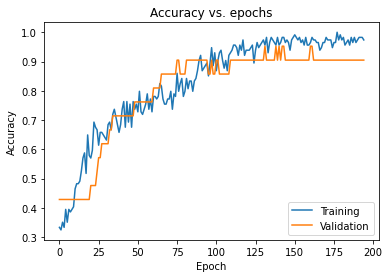

In [14]:
#accuracy vs epochs graph
try:
    plt.plot(call_history.history['accuracy'])
    plt.plot(call_history.history['val_accuracy'])
except KeyError:
    plt.plot(call_history.history['acc'])
    plt.plot(call_history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

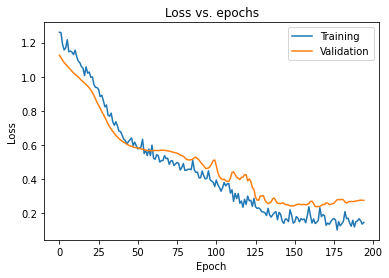

In [15]:
#accuracy vs loss graph
plt.plot(call_history.history['loss'])
plt.plot(call_history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [16]:
#model evaluation
test_loss, test_acc = call_model.evaluate(test_data, test_targets, verbose = 0)
print("Test loss: {:.4f}\nTest accuracy: {:.2f}%".format(test_loss, 100*test_acc))

Test loss: 0.0862
Test accuracy: 100.00%
